In [126]:
from matplotlib import pyplot as plt

In [127]:
import os
from tqdm import tqdm
import pathlib
import numpy as np
import pandas as pd
import pickle
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import MinMaxScaler

import torch as t

from datetime import datetime as dt

DEVICE = "cuda" if t.cuda.is_available() else 'cpu'

tqdm.pandas()
pd.set_option('display.max_columns', None)

In [128]:
DATA_DIR = pathlib.Path("./data/")
RS = 3984765

In [129]:
train = pd.read_parquet(DATA_DIR.joinpath("train.parquet"))
index_split = int(train.shape[0] * 0.15)
test = train[index_split:]
train = train[:index_split]
test.shape

(130405, 27)

In [130]:
train["feature0"].quantile(0.99)

63.22948411242339

In [131]:


class Pipe:
    def __init__(self, cols_to_short, batch_size=64):
        self.min_max = MinMaxScaler()
        self.cols_to_short = cols_to_short
        self.batch_size = batch_size


    def fit(self, X: pd.DataFrame):
        X_ = self.quntize(X)
        X_["feature4"] = (X_["feature4"] == "gas1") * 1
        self.min_max.fit(X_)

    def quntize(self, X):
        X_ = X.copy()
        
        for col in self.cols_to_short:
            X_ = X_[X_[col] < X_[col].quantile(0.999)]
        
        return X_

    def transform(self, X, y=None, train_df=False):
        X_ = X.copy()
        if y is not None:
            y_ = y.copy()


        if train_df:
            X_ = self.quntize(X_)
        if train_df and y is not None:
            y_ = y_.iloc[X_.index]
        

        X_["feature4"] = (X_["feature4"] == "gas1") * 1
        

        X_ = pd.DataFrame(self.min_max.transform(X_), columns=X_.columns) 
        X_["cluster"] = (X_["feature4"] == 1) * 1
        X_.drop("feature4", axis=1, inplace=True)

        X_t = t.tensor(X_.to_numpy(), dtype=t.float32)

        if y is not None:
            y_t = t.tensor(y_.to_numpy(), dtype=t.float32)
            ds = t.utils.data.TensorDataset(X_t, y_t)
        else:
            ds = t.utils.data.TensorDataset(X_t)

        ldr = t.utils.data.DataLoader(ds, batch_size=self.batch_size)

        return ds, ldr
    
    def pack(self, path):
        to_pack = {
            "scaler" : self.min_max,
            "cols" : self.cols_to_short,
            "batch_size" : self.batch_size
        }
        with open(path, "wb+") as f:
            pickle.dump(to_pack, f)
    
    def unpack(self, path):
        with open(path, "rb") as f:
            params = pickle.load(f)

        self.batch_size = params["batch_size"]
        self.min_max = params["scaler"]
        self.cols_to_short = params["cols"] 

    
    

pipe = Pipe(cols_to_short=[
    "feature0",
    "feature1",
    "feature2",
    "feature3",
    "feature5",
    "feature7",
    "feature12",
    "feature15",
    "feature17",
    ], batch_size=512)

pipe.fit(train.drop(["target0", "target1"], axis=1))


In [132]:
print(train.shape)
train_ds, train_ldr = pipe.transform(
    train.drop(["target0", "target1"], axis=1), 
    train[["target0", "target1"]],
    train_df=True)
print(train_ds.tensors[0].shape)

print(test.shape)
test_ds, test_ldr = pipe.transform(
    test.drop(["target0", "target1"], axis=1),
    test[["target0", "target1"]]
    )
print(test_ds.tensors[0].shape)

(23012, 27)
torch.Size([22804, 25])
(130405, 27)
torch.Size([130405, 25])


In [133]:
class fc_model(t.nn.Module):
    def __init__(self, input_dim, layers=[256, 16, 2], device='cpu'):
        super().__init__()
        self.device=device

        self.zero = t.nn.Sequential(
            t.nn.Linear(input_dim, layers[0]),
            t.nn.ReLU(),
            

            t.nn.Linear(layers[0], layers[1]),
            t.nn.ReLU(),
            t.nn.Linear(layers[1], layers[2])
        )
        self.one = t.nn.Sequential(
            t.nn.Linear(input_dim, layers[0]),
            
            t.nn.ReLU(),
            t.nn.Linear(layers[0], layers[1]),
            
            t.nn.ReLU(),
            t.nn.Linear(layers[1], layers[2])
        )

    def forward(self, X):
        out = t.zeros((X.shape[0], 2), device=self.device, dtype=t.float32)
        
        inds_one = (X[:, -1] == t.scalar_tensor(1)).nonzero().T[0]
        inds_zero = (X[:, -1] == t.scalar_tensor(0)).nonzero().T[0]

        one = self.one(X[inds_one]) 
        
        zero = self.zero(X[inds_zero]) 

        out[inds_one] = one
        out[inds_zero] = zero

        return out



In [134]:


def train(train_ldr, 
          test_ldr, 
          model, 
          optimizer, 
          loss_f, 
          epochs=10, 
          device='cpu',
          sm = None,
          save_each = 20):
    
    global pipe

    bar = tqdm(range(epochs))
    for epoch in bar:
        loss_cum = 0
        for X, y in train_ldr:
            optimizer.zero_grad()
            out = model(X.to(device=device))
            loss = loss_f(out, y.to(device=device))
            loss.backward()
            loss_cum += loss
            optimizer.step()

        eval_test = eval(test_ldr, model, device)
        eval_train = eval(train_ldr, model, device)
        bar.set_description(f'''epoch {epoch}, loss {loss_cum:.3f}, mape_train {(eval_train * 100).round(2)}, mape_test {(eval_test * 100).round(2)}''')
        if sm is not None:
            sm.add_scalar('Loss/train', loss_cum, epoch)
            sm.add_scalar('MAPE/train', eval_train.sum() / 2, epoch)
            sm.add_scalar('MAPE/test', eval_test.sum() / 2, epoch)
        if epoch % 10 == 0:
            save_model(model, pipe, "./models/", "fc_")




def eval(test_ldr, model, device='cpu'):
    
    loss = np.array([0, 0], dtype=np.float32)
    i=0
    for X, y in test_ldr:
        with t.no_grad():
            out = model(X.to(device=device))
            loss += mape(y, out.cpu().detach().numpy(), multioutput='raw_values')
            i+=1

    return loss / i

def pred(ldr, model, device='cpu'):
    res = t.tensor([], dtype=t.float32)

    with t.no_grad():
        for X, y in ldr:
            out = model(X.to(device=device)).to('cpu')
            res = t.cat([res,out], axis=0)
    
    res = pd.DataFrame(
        res.detach().numpy(),
        columns = ["target0", "target1"]
    )

    return res



def save_model(model, pipe, path, prefix):
    timestamp = dt.now().strftime('%Y-%m-%d %H:%M:%S')
    filename_m = prefix + "model_" + timestamp + ".t"
    filename_p = prefix + "pipe_" + timestamp + ".pckl"
    
    t.save(model.state_dict(), path + filename_m)
    pipe.pack(path + filename_p)

    

In [135]:
model = fc_model(train_ds.tensors[0].shape[1], layers=[256, 16, 2], device=DEVICE).to(device=DEVICE)
optimizer = t.optim.Adam(model.parameters())
loss_f = t.nn.MSELoss()

sm = SummaryWriter("./runs")

train(train_ldr, test_ldr, model, optimizer, loss_f, 500, DEVICE, sm)
save_model(model, pipe, "./models/", "model_linear_")

epoch 499, loss 23.720, mape_train [0.99 3.12], mape_test [1.02 3.14]: 100%|██████████| 500/500 [05:57<00:00,  1.40it/s]       


In [136]:
# train(train_ldr, test_ldr, model, optimizer, loss_f, 200, DEVICE, sm)
# save_model(model, pipe, "./models/", "model_linear_")

In [137]:
model_ = fc_model(25, [512, 64, 2], DEVICE)
model_.load_state_dict(t.load("./submission/model.t"))
model_ = model_.cpu()

RuntimeError: Error(s) in loading state_dict for fc_model:
	size mismatch for zero.0.weight: copying a param with shape torch.Size([256, 25]) from checkpoint, the shape in current model is torch.Size([512, 25]).
	size mismatch for zero.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for zero.2.weight: copying a param with shape torch.Size([16, 256]) from checkpoint, the shape in current model is torch.Size([64, 512]).
	size mismatch for zero.2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for zero.4.weight: copying a param with shape torch.Size([2, 16]) from checkpoint, the shape in current model is torch.Size([2, 64]).
	size mismatch for one.0.weight: copying a param with shape torch.Size([256, 25]) from checkpoint, the shape in current model is torch.Size([512, 25]).
	size mismatch for one.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for one.2.weight: copying a param with shape torch.Size([16, 256]) from checkpoint, the shape in current model is torch.Size([64, 512]).
	size mismatch for one.2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for one.4.weight: copying a param with shape torch.Size([2, 16]) from checkpoint, the shape in current model is torch.Size([2, 64]).

In [ ]:
model_.device = 'cpu'
eval(test_ldr, model_)

array([0.00533095, 0.0228748 ], dtype=float32)

In [ ]:
pipe.pack("./src/pipe.pckl")
pipe = Pipe([])
pipe.unpack("./src/pipe.pckl")

In [ ]:
pipe.transform(test.drop(["target0", "target1"], axis=1))

(<torch.utils.data.dataset.TensorDataset at 0x7fdd3472c1f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdcc2f4bf10>)

In [ ]:
with open("./src/pipe_2023-05-27 18:20:59.pckl", "rb") as f:
    pipe_ = pickle.load(f)

In [ ]:
preds = pred(test_ldr, model,DEVICE).to_numpy()
diff = preds - test[["target0", "target1"]].to_numpy()


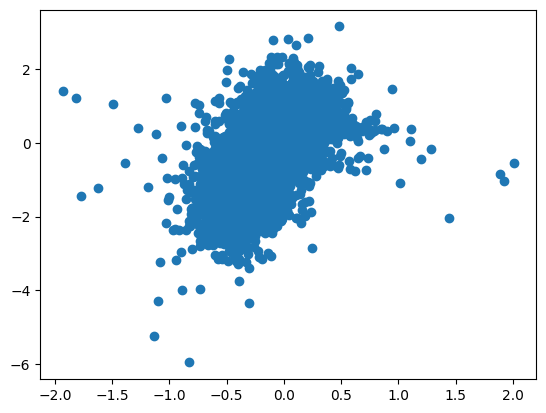

In [ ]:
plt.scatter(diff[:,0], diff[:,1])